In [14]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm_notebook

import fannypack
from lib import dpf, panda_datasets, panda_baseline_models, panda_baseline_training


In [43]:
# Experiment configuration
experiment_name = "lstm_feb22_biggerset_noimage"
dataset_args = {
    'use_proprioception': True,
    'use_haptics': True,
    'use_vision': True,
    'vision_interval': 2,
}

In [44]:
print("Creating model...")
model = panda_baseline_models.PandaLSTMModel(batch_size=16)
buddy = fannypack.utils.Buddy(experiment_name, model)

Creating model...
[buddy-lstm_feb22_biggerset_noimage] Using device: cuda
[buddy-lstm_feb22_biggerset_noimage] No checkpoint found


In [45]:
print("Creating dataset...", dir(panda_datasets))
dataset = panda_datasets.PandaSubsequenceDataset(
    'data/gentle_push_10.hdf5',
    subsequence_length=16,
    **dataset_args)

Creating dataset... ['PandaDynamicsDataset', 'PandaMeasurementDataset', 'PandaParticleFilterDataset', 'PandaSubsequenceDataset', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_print_normalization', 'dpf', 'load_trajectories', 'np', 'scipy', 'torch', 'tqdm_notebook', 'utils']


In [47]:
buddy.set_learning_rate(1e-3)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=16, shuffle=True, num_workers=2, drop_last=True)
model.batch_size = 16
for _ in tqdm_notebook(range(300)):
    for batch_idx, batch in enumerate(tqdm_notebook(dataloader)):
        states, observations, controls = fannypack.utils.to_device(batch, buddy.device)
#         states = states *0 + 0.1
        model.reset_hidden_states(states[:, 0, :])
#         model.reset_hidden_states(
#             fannypack.utils.to_torch(np.random.normal(0, 1, size=states[:, 0, :].shape), device=buddy.device)
#         )
        predicted_states = torch.cat([
            states[:,0:1,:],
            model(
                fannypack.utils.DictIterator(observations)[:,1:],
                controls[:,1:],
            ),
        ], axis=1)
        assert predicted_states.shape == states.shape
        loss = F.mse_loss(predicted_states, states)
        buddy.minimize(loss, checkpoint_interval=500)
        
        with buddy.log_scope("lstm_training"):
            buddy.log("loss", loss)
            buddy.log("predicted_states_mean", predicted_states.mean())
            buddy.log("predicted_states_std", predicted_states.std())
            buddy.log("label_states_mean", states.mean())
            buddy.log("label_states_std", states.std())

buddy.save_checkpoint()

[buddy-lstm_feb22_biggerset_noimage] Saved checkpoint to path: checkpoints/lstm_feb22_biggerset_noimage-0000000000001000.ckpt



[buddy-lstm_feb22_biggerset_noimage] Saved checkpoint to path: checkpoints/lstm_feb22_biggerset_noimage-0000000000001500.ckpt



[buddy-lstm_feb22_biggerset_noimage] Saved checkpoint to path: checkpoints/lstm_feb22_biggerset_noimage-0000000000002000.ckpt



[buddy-lstm_feb22_biggerset_noimage] Saved checkpoint to path: checkpoints/lstm_feb22_biggerset_noimage-0000000000002500.ckpt



[buddy-lstm_feb22_biggerset_noimage] Saved checkpoint to path: checkpoints/lstm_feb22_biggerset_noimage-0000000000003000.ckpt





[buddy-lstm_feb22_biggerset_noimage] Saved checkpoint to path: checkpoints/lstm_feb22_biggerset_noimage-0000000000003211.ckpt


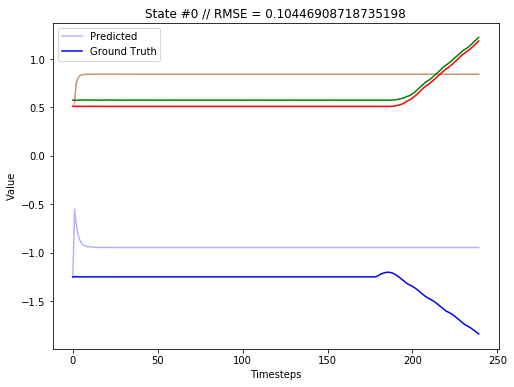

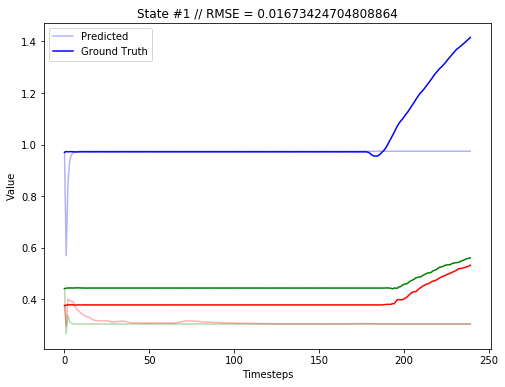

In [48]:
eval_trajectories = panda_datasets.load_trajectories(("data/gentle_push_10.hdf5", 3), **dataset_args)

pred, actual = panda_baseline_training.rollout_lstm(model, eval_trajectories)
panda_baseline_training.eval_rollout(pred, actual, plot=True)

In [ ]:
pred, actual = panda_baseline_training.rollout_lstm(model, eval_trajectories)
panda_baseline_training.eval_rollout(pred, actual, plot=True)

In [ ]:
buddy.save_checkpoint("stable")

In [ ]:
buddy.save_checkpoint()